期权合约月份：['202102', '202103', '202106', '202109']


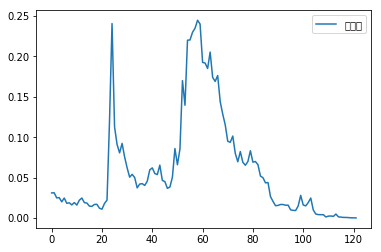

<class 'pandas.core.frame.DataFrame'>


In [58]:
# python3
from json import loads
from requests import get
import pandas as pd
import matplotlib.pyplot as plt

#参考下面文章继续加工，期权
#尝试获取已经过期的期权数据
#https://blog.csdn.net/u013781175/article/details/54374798
 
def get_option_dates(cate='50ETF', exchange='null'):
    url = f"http://stock.finance.sina.com.cn/futures/api/openapi.php/StockOptionService.getStockName?" \
          f"exchange={exchange}&cate={cate}"
    dates = get(url).json()['result']['data']['contractMonth']
    return [''.join(i.split('-')) for i in dates][1:]
 
 
def get_option_expire_day(date, cate='50ETF', exchange='null'):
    url = "http://stock.finance.sina.com.cn/futures/api/openapi.php/StockOptionService.getRemainderDay?" \
          "exchange={exchange}&cate={cate}&date={year}-{month}"
    url2 = url.format(year=date[:4], month=date[4:], cate=cate, exchange=exchange)
    data = get(url2).json()['result']['data']
    if int(data['remainderDays']) < 0:
        url2 = url.format(year=date[:4], month=date[4:], cate='XD' + cate, exchange=exchange)
        data = get(url2).json()['result']['data']
    return data['expireDay'], int(data['remainderDays'])
 
 
def get_option_codes(date, underlying='510050'):
    url_up = ''.join(["http://hq.sinajs.cn/list=OP_UP_", underlying, str(date)[-4:]])
    url_down = ''.join(["http://hq.sinajs.cn/list=OP_DOWN_", underlying, str(date)[-4:]])
    data_up = str(get(url_up).content).replace('"', ',').split(',')
    codes_up = [i[7:] for i in data_up if i.startswith('CON_OP_')]
    data_down = str(get(url_down).content).replace('"', ',').split(',')
    codes_down = [i[7:] for i in data_down if i.startswith('CON_OP_')]
    return codes_up, codes_down
 
 
def get_option_price(code):
    url = "http://hq.sinajs.cn/list=CON_OP_{code}".format(code=code)
    data = get(url).content.decode('gbk')
    data = data[data.find('"') + 1: data.rfind('"')].split(',')
    fields = ['买量', '买价', '最新价', '卖价', '卖量', '持仓量', '涨幅', '行权价', '昨收价', '开盘价', '涨停价',
              '跌停价', '申卖价五', '申卖量五', '申卖价四', '申卖量四', '申卖价三', '申卖量三', '申卖价二',
              '申卖量二', '申卖价一', '申卖量一', '申买价一', '申买量一 ', '申买价二', '申买量二', '申买价三',
              '申买量三', '申买价四', '申买量四', '申买价五', '申买量五', '行情时间', '主力合约标识', '状态码',
              '标的证券类型', '标的股票', '期权合约简称', '振幅', '最高价', '最低价', '成交量', '成交额',
              '分红调整标志', '昨结算价', '认购认沽标志', '到期日', '剩余天数', '虚实值标志', '内在价值', '时间价值']
    result = list(zip(fields, data))
    return result
 
 
def get_underlying_security_price(code='sh510050'):
    url = "http://hq.sinajs.cn/list=" + code
    data = get(url).content.decode('gbk')
    data = data[data.find('"') + 1: data.rfind('"')].split(',')
    fields = ['证券简称', '今日开盘价', '昨日收盘价', '最近成交价', '最高成交价', '最低成交价', '买入价',
              '卖出价', '成交数量', '成交金额', '买数量一', '买价位一', '买数量二', '买价位二', '买数量三',
              '买价位三', '买数量四', '买价位四', '买数量五', '买价位五', '卖数量一', '卖价位一', '卖数量二',
              '卖价位二', '卖数量三', '卖价位三', '卖数量四', '卖价位四', '卖数量五', '卖价位五', '行情日期',
              '行情时间', '停牌状态']
    return list(zip(fields, data))
 
 
def get_option_greek_alphabet(code):
    url = "http://hq.sinajs.cn/list=CON_SO_{code}".format(code=code)
    data = get(url).content.decode('gbk')
    data = data[data.find('"') + 1: data.rfind('"')].split(',')
    fields = ['期权合约简称', '成交量', 'Delta', 'Gamma', 'Theta', 'Vega', '隐含波动率', '最高价', '最低价',
              '交易代码', '行权价', '最新价', '理论价值']
    return list(zip(fields, [data[0]] + data[4:]))
 
 
def get_option_time_line(code):
    url = f"https://stock.finance.sina.com.cn/futures/api/openapi.php/StockOptionDaylineService.getOptionMinline?" \
          f"symbol=CON_OP_{code}"
    data = get(url).json()['result']['data']
    return data
 
 
def get_option_day_kline(code):
    url = f"http://stock.finance.sina.com.cn/futures/api/jsonp_v2.php//StockOptionDaylineService.getSymbolInfo?" \
          f"symbol=CON_OP_{code}"
    data = get(url).content
    data = loads(data[data.find(b'(') + 1: data.rfind(b')')])
    return data
 
 
def my_test():
    dates = get_option_dates(cate='50ETF')
    print('期权合约月份：{}'.format(dates))
#     for date in dates:
#         print('期权月份{}：到期日{} 剩余天数{}'.format(date, *get_option_expire_day(date, cate='300ETF')))
    demo_code = '10002180'
#     for date in dates:
#         call_codes, put_codes = get_option_codes(date, underlying='510300')
#         print('期权月份{} 看涨期权代码：{}\n期权月份{} 看跌期权代码：{}'.format(date, call_codes, date, put_codes))
#         demo_code = call_codes[0]
#     for index, i in enumerate(get_option_price(demo_code)):
#         print('期权' + demo_code, index, *i)
#     for index, i in enumerate(get_underlying_security_price(code='sh510300')):
#         print(index, *i)
#     for index, i in enumerate(get_option_greek_alphabet(demo_code)):
#         print('期权' + demo_code, index, *i)
#     time_line = get_option_time_line(demo_code)
#     for i in time_line[-10:]:
#         print('时间:{i}, 价格:{p}, 成交:{v}, 持仓:{t}, 均价:{a}'.format(**i))
    day_kline = get_option_day_kline(demo_code)
    list_date=[]
    list_price=[]
    for i in day_kline:
        #print('日期:{d},开盘:{o}, 最高:{h}, 最低:{l}, 收盘:{c}, 成交:{v}'.format(**i))
        string_data = '{d}'.format(**i)
        string_price='{o}'.format(**i)
        #print(type(string))
        list_date.append(string_data)
        list_price.append(string_price)
        #print(list_price)
        #list_data.to_csv("D:\yewenwu\option\50etf.csv")
        #string.to_csv('D:\yewenwu\option\50etf.csv')
    new_data={'日期':list_date,'开盘价':list_price} #构造字典
    df=pd.DataFrame(new_data)
    
    showprice=df[['开盘价']]
    showprice=showprice.astype(float)
#     print(type(showprice))
#     print(showprice)
    showprice.plot()
    plt.show()
    
    print(type(df))
    
    df.to_csv("D:\yewenwu\option\etf.csv")
#     showprice=df[['开盘价']]
#     showprice.plot()
#     plt.show()
    
 
if __name__ == '__main__':
    my_test()